In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/NLP/nlp project

/content/gdrive/My Drive/Colab Notebooks/NLP/nlp project


In [2]:
import pandas as pd
import numpy as np
import os
import string

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Input, Bidirectional, GlobalMaxPool1D, Concatenate, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
from spacy import displacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Loading news dataset,

In [4]:
news = pd.read_csv('apple_news.csv')

#replace NAN with 'Hello World'
news = news.replace(np.nan, 'HELLO WORLD', regex=True)

#convert to datetime
news['date'] = pd.to_datetime(news['date'])
news.head()

,date,news
0,2006-12-01,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,2006-12-04,More on Housing Prices : The broadest governme...
2,2006-12-05,HELLO WORLD
3,2006-12-06,Honoring R.W. Apple in Words and Food : About ...
4,2006-12-07,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [5]:
nlp = spacy.load('en_core_web_sm')
text = nlp(news['news'][6])
displacy.render(text, style='ent', jupyter=True)

In [6]:
#nltk sentiment analyser
sia = SentimentIntensityAnalyzer()

#perform sentiment analysis
sentiment = news['news'].apply(lambda news: sia.polarity_scores(news))

#filter the compound values only
news['polarity'] = [sentiment[r]['compound'] for r in range(len(sentiment))]
news.head()

,date,news,polarity
0,2006-12-01,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...,0.7707
1,2006-12-04,More on Housing Prices : The broadest governme...,0.8720
2,2006-12-05,HELLO WORLD,0.0000
3,2006-12-06,Honoring R.W. Apple in Words and Food : About ...,0.6858
4,2006-12-07,"Homebuilders, and Worries Over Jobs, Lead a De...",-0.6712


Remove stopwords and punctuations

In [7]:
stopwords_list = set(stopwords.words('english'))
sentences = news['news']

stop_removed = []
punc_removed = []
        
for data in sentences:
  words = word_tokenize(data)
  filtered = []
  
  filtered.append([w if w not in stopwords_list else '' for w in words])
  stop_removed.append(filtered)
  

punc_removed.extend([str(row).lower().translate(str.maketrans('', '', string.punctuation)) for row in stop_removed])
news['news_cleaned'] = punc_removed
news.head()

,date,news,polarity,news_cleaned
0,2006-12-01,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...,0.7707,what s on tonight 8 pm tlc ashley judd and ...
1,2006-12-04,More on Housing Prices : The broadest governme...,0.8720,more housing prices the broadest government ...
2,2006-12-05,HELLO WORLD,0.0000,hello world
3,2006-12-06,Honoring R.W. Apple in Words and Food : About ...,0.6858,honoring rw apple words food about 1000 r...
4,2006-12-07,"Homebuilders, and Worries Over Jobs, Lead a De...",-0.6712,homebuilders worries over jobs lead declin...


In [8]:
sentences = punc_removed

print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))

s = sorted(len(s) for s in sentences)
print('median sequence length: ', s[len(s)//2])

max sequence length:  4089
min sequence length:  11
median sequence length:  1439


In [0]:
MAX_SEQUENCE_LENGTH = max(len(s) for s in sentences)
MAX_VOCAB_SIZE = 40000
EMBEDDING_DIM = 200

Loading Glove word vectors

In [10]:
word2vec = {}

with open(os.path.join ('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype='float32')
    word2vec[word] = vec
    
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [0]:
#tokenisation

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [12]:
word2idx = tokenizer.word_index
print('found %d unique tokens' %len(word2idx))

found 43101 unique tokens


In [13]:
#padding the sequences

news_vector_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('shape of the tensor: ', news_vector_data.shape)

shape of the tensor:  (2517, 4089)


Filling pretrained embeddings

In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix.shape

(40000, 200)

In [16]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21752   , -0.11792   , -0.088778  , ...,  0.27641001,
         0.14048   ,  0.99224001],
       [-0.11359   ,  0.20144001, -0.47073999, ..., -0.42846   ,
         0.37869   , -0.52864999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
news_vec = []
news_vec.extend([news_vector_data[x] for x in range(len(news_vector_data))])

news['news_vector'] = news_vec

news.head()

,date,news,polarity,news_cleaned,news_vector
0,2006-12-01,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...,0.7707,what s on tonight 8 pm tlc ashley judd and ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2006-12-04,More on Housing Prices : The broadest governme...,0.8720,more housing prices the broadest government ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2006-12-05,HELLO WORLD,0.0000,hello world,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2006-12-06,Honoring R.W. Apple in Words and Food : About ...,0.6858,honoring rw apple words food about 1000 r...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2006-12-07,"Homebuilders, and Worries Over Jobs, Lead a De...",-0.6712,homebuilders worries over jobs lead declin...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
market = pd.read_csv('apple_market.csv')
market['date'] = pd.to_datetime(market['date'])
market.head()

,date,open,high,low,close,volume
0,2006-12-01,13.114285,13.190000,12.871428,13.045714,198769900
1,2006-12-04,13.125714,13.150000,12.928572,13.017143,177384200
2,2006-12-05,13.092857,13.190000,12.981428,13.038571,165709600
3,2006-12-06,12.948571,13.055715,12.810000,12.832857,159546100
4,2006-12-07,12.861428,12.928572,12.414286,12.434286,251206900


In [19]:
a = market['open']
a = a[1:,]
a = a.tolist()
a.append(0)
market['target'] = a

market.head()

,date,open,high,low,close,volume,target
0,2006-12-01,13.114285,13.190000,12.871428,13.045714,198769900,13.125714
1,2006-12-04,13.125714,13.150000,12.928572,13.017143,177384200,13.092857
2,2006-12-05,13.092857,13.190000,12.981428,13.038571,165709600,12.948571
3,2006-12-06,12.948571,13.055715,12.810000,12.832857,159546100,12.861428
4,2006-12-07,12.861428,12.928572,12.414286,12.434286,251206900,12.461429


In [20]:
df = pd.merge(left=market, right=news, how='left', on='date', copy=False)
df = df[['date', 'high', 'low', 'volume', 'news_vector', 'polarity', 'target']]
df.head()

,date,high,low,volume,news_vector,polarity,target
0,2006-12-01,13.190000,12.871428,198769900,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.7707,13.125714
1,2006-12-04,13.150000,12.928572,177384200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.8720,13.092857
2,2006-12-05,13.190000,12.981428,165709600,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0000,12.948571
3,2006-12-06,13.055715,12.810000,159546100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.6858,12.861428
4,2006-12-07,12.928572,12.414286,251206900,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.6712,12.461429


In [21]:
len(df)

2517

In [0]:
news = news_vector_data
polarity = np.array(df['polarity'])
stock = np.array(df[['high', 'low', 'volume']])
target = np.array(df['target'])

In [0]:
news_train, news_test, polarity_train, polarity_test, stock_train, stock_test, target_train, target_test = train_test_split(news, polarity, stock, target, train_size=0.9, shuffle=False)

In [0]:
#custom embedding layer

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [0]:
#model

in_news = Input(shape=(MAX_SEQUENCE_LENGTH,))
in_stock = Input(shape=(3,))

news = embedding_layer(in_news)
news = Bidirectional(LSTM(10, return_sequences=True))(news)
news = GlobalMaxPool1D()(news)
news_out = Dense(1)(news)

stock = Dense(64)(in_stock)
stock = Dense(512)(stock)
stock = Dense(1)(stock)

concat = Concatenate(axis=1)([news_out, stock])

out = Dense(512)(concat)
#out = Dense(512)(out)
output = Dense(1)(out)


#setting 2 outputs, one is the actual prediction and other is for backpropagate news
model = Model([in_news, in_stock], [output, news_out])


model.compile(loss=['mae', 'logcosh'], optimizer='adam')

In [0]:
#define callbacks and early stopping
callback = [ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1), EarlyStopping(monitor='val_loss', patience=30)]

In [89]:
history = model.fit([news_train, stock_train], [target_train, polarity_train], batch_size=128, epochs=10, validation_split=0.1)

Train on 2038 samples, validate on 227 samples
Epoch 1/10
2038/2038 [==============================] - 9s 4ms/step - loss: 470242.4826 - dense_102_loss: 470242.3298 - dense_97_loss: 0.1541 - val_loss: 51638.0232 - val_dense_102_loss: 51637.8761 - val_dense_97_loss: 0.1457
Epoch 2/10
2038/2038 [==============================] - 6s 3ms/step - loss: 89009.7809 - dense_102_loss: 89009.6394 - dense_97_loss: 0.1424 - val_loss: 6114.4481 - val_dense_102_loss: 6114.3072 - val_dense_97_loss: 0.1406
Epoch 3/10
2038/2038 [==============================] - 6s 3ms/step - loss: 6307.6374 - dense_102_loss: 6307.4991 - dense_97_loss: 0.1382 - val_loss: 5865.7145 - val_dense_102_loss: 5865.5765 - val_dense_97_loss: 0.1381
Epoch 4/10
2038/2038 [==============================] - 6s 3ms/step - loss: 9494.5239 - dense_102_loss: 9494.3890 - dense_97_loss: 0.1348 - val_loss: 2608.2761 - val_dense_102_loss: 2608.1394 - val_dense_97_loss: 0.1367
Epoch 5/10
2038/2038 [==============================] - 6s 3ms/st

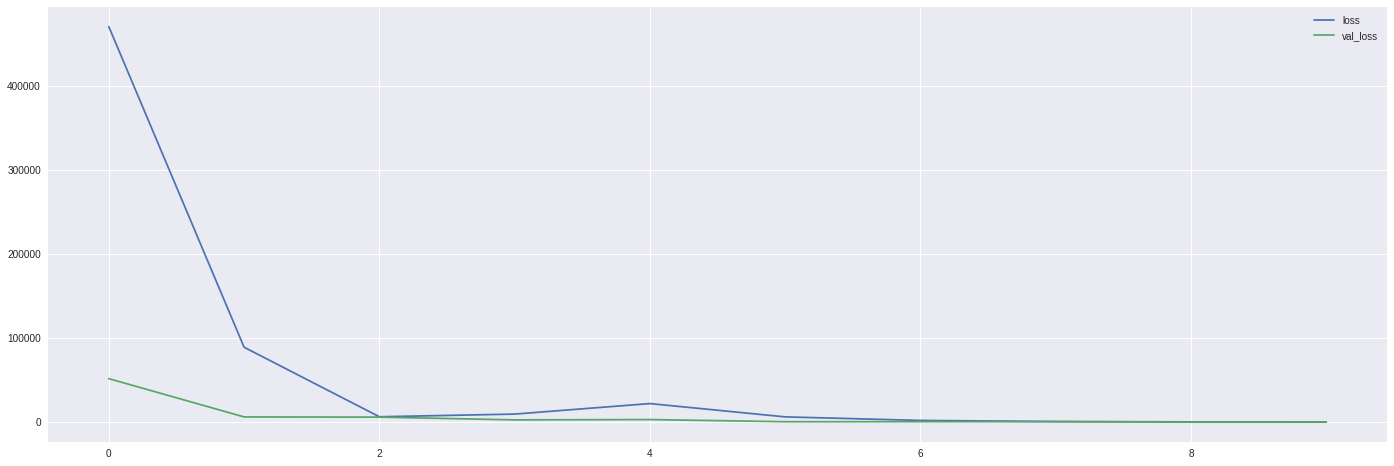

In [90]:
#overall loss
plt.figure(figsize=(24,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

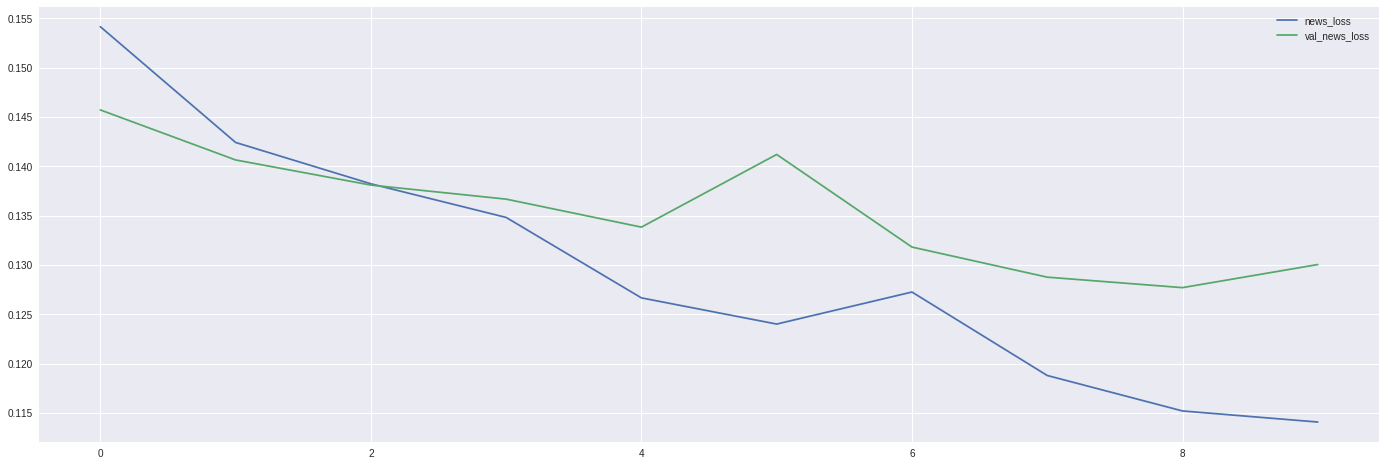

In [91]:
#news output loss
plt.figure(figsize=(24,8))
plt.plot(history.history['dense_97_loss'], label='news_loss')
plt.plot(history.history['val_dense_97_loss'], label='val_news_loss')
plt.legend()
plt.show()

In [0]:
predictions, _ = model.predict([news_test[:250,], stock_test[:250,]])

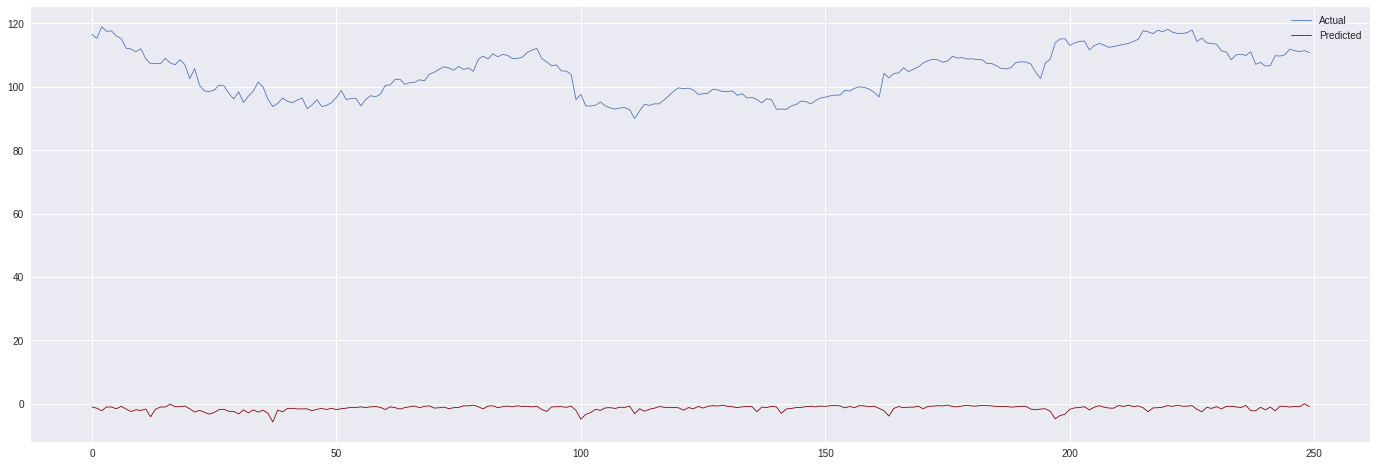

In [93]:
#plot

plt.figure(figsize=(24,8))
cycles = np.arange(len(predictions))
plt.plot(cycles, target_test[:250,], label="Actual", lw=0.8)
plt.plot(cycles, predictions, 'maroon', label="Predicted", lw=0.8)
plt.legend()
plt.show()